# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells run and is stored in your team's [Github Classroom repository](https://classroom.github.com/a/CNxME27U). You will also need to write a short, 2 page report about your design decisions as a team, to be stored in your repository. The Milestone 4 submission will be the contents of your repository at the due date (April 28 at 23:59 CET).

## Brief overview of Calcularis
[Calcularis](https://school.alemira.com/de/calcularis/) by Alemira School is a mathematics learning program developed with neuroscientists and computer scientists from ETH Zurich. It promotes the development and interaction of the different areas of the brain that are responsible for processing numbers and quantities and solving mathematical tasks. Calcularis can be used from 1st grade to high school. Children with dyscalculia also benefit in the long term and overcome their arithmetic weakness.

The Calcularis dataset has three main tables:
* ***users***: meta information about users (i.e. total time spent learning with Calcularis, geographic location).
* ***events***: events done by the users in the platform (i.e. playing a game, selecting a new animal in the zoo simulation).
* ***subtasks***: sub-tasks with answer attempts solved by users, primarily in the context of game events.

These tables and useful metadata information are described in detail in the [Milestone 2 data exploration notebook](https://github.com/epfl-ml4ed/mlbd-2023/blob/main/project/milestone-02/m2_calcularis_sciper.ipynb).

We have provided access to the [full dataset](https://moodle.epfl.ch/mod/forum/discuss.php?d=88179) (~65k users) and a randomly selected subset (~1k users from M2). We have also provided access to a [test account to experiment with Calcularis](https://moodle.epfl.ch/mod/forum/discuss.php?d=88094). You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [3]:
#import packages
import numpy as np
import random
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import euclidean, pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.sparse.csgraph import laplacian
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import spectral_embedding
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix,
                              _return_path, _blurred_path_region)


In [4]:
# Import the tables of the data set as dataframes.

DATA_DIR_full_dataset = './../../../data_mlbd/data project/' # You many change the directory
DATA_DIR_small_dataset = './../../../data_mlbd/00_data_1000_students/'

# You can use the nrows=X argument in pd.read_csv to truncate your data
#users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR_small_dataset), index_col=0)
#events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR_small_dataset), index_col=0)
#subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR_small_dataset), index_col=0)
users = pd.read_csv('{}/full_calcularis_users.csv'.format(DATA_DIR_full_dataset), index_col=0)
events = pd.read_csv('{}/full_calcularis_events.csv'.format(DATA_DIR_full_dataset), index_col=0)
subtasks = pd.read_csv('{}/full_calcularis_subtasks.csv'.format(DATA_DIR_full_dataset), index_col=0)

In [5]:
print(f'Number of users: {len(users)}')
print(f'Number of events: {len(events)}')
print(f'Number of subtasks: {len(subtasks)}')

Number of users: 64932
Number of events: 2185200
Number of subtasks: 3502884


In [6]:
users.head()

,learning_time_ms,logged_in_time_ms,language,country,start,end
user_id,,,,,,
2,188171589,588863379,nl,NL,2020-08-20T07:13:38.940Z,2022-12-21T08:43:02.329Z
3,51674473,64077203,de,NaN,2018-02-23T08:29:29.769Z,2019-02-01T09:50:40.447Z
4,73967025,128230675,de,CH,2021-09-06T13:31:50.872Z,2023-02-10T07:57:49.752Z
5,41135378,58146142,de,CH,2022-02-22T10:41:26.754Z,2023-01-24T15:11:29.666Z
6,37110540,61017222,de,CH,2021-10-07T09:23:18.558Z,2022-02-14T18:03:09.583Z


In [7]:
events.head()

,user_id,mode,game_name,learning_time_ms,subtasks,number_range,start,end,skill_id,type
event_id,,,,,,,,,,
1,2,NORMAL,Subitizing,13094.0,"[{'hasProperResult': True, 'range': 'R10', 'co...",R10,2020-08-20T07:13:50.876Z,2020-08-20T07:14:30.108Z,1.0,task
3,2,NORMAL,Conversion,15879.0,"[{'answer': 6, 'range': 'R10', 'correct': True...",R10,2020-08-21T07:02:20.112Z,2020-08-21T07:02:36.221Z,3.0,task
4,2,NORMAL,Landing,6075.0,"[{'range': 'R10', 'correct': True, 'lowerBound...",R10,2020-08-24T07:02:59.855Z,2020-08-24T07:03:07.382Z,18.0,task
5,2,NORMAL,Landing,6910.0,"[{'range': 'R10', 'correct': True, 'lowerBound...",R10,2020-08-26T06:47:21.504Z,2020-08-26T06:47:30.050Z,19.0,task
6,2,NORMAL,Calculator,7507.0,"[{'range': 'R20', 'answerMode': 'RESULT', 'cor...",R20,2020-08-26T07:20:58.766Z,2020-08-26T07:21:06.439Z,54.0,task


In [8]:
subtasks.head()

,event_id,user_id,aim,answer,answerMode,availableNumbers,correct,correctAnswerObject,correctNumber,destination,...,timeoutInSeconds,timeoutInSteps,type,upperBound,step,orderIndependent,divisor,larger,smaller,timeout
subtask_id,,,,,,,,,,,,,,,,,,,,,
1,1,2,NaN,4,NaN,NaN,False,1,1.0,NaN,...,NaN,NaN,ConciseSubitizingTaskDescription,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,NaN,2,NaN,NaN,True,NaN,NaN,NaN,...,0.0,2.0,ConciseTimeoutDescription,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2,NaN,6,NaN,NaN,True,6,NaN,ARABIC,...,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2,7.0,"{'b': 6.7354193, 'a': 7}",NaN,NaN,True,"{'b': 7.0, 'a': 7}",NaN,NaN,...,NaN,NaN,ConciseLandingTaskDescription,7.5,NaN,NaN,NaN,NaN,NaN,NaN
5,5,2,1.0,"{'b': 1.0453212, 'a': 1}",NaN,NaN,True,"{'b': 1.0, 'a': 1}",NaN,NaN,...,NaN,NaN,ConciseLandingTaskDescription,1.5,NaN,NaN,NaN,NaN,NaN,NaN


## Task 0: Research Question

**Research question:**

Time series clustering per student to look at the difference between guided training and free training, with the goal of learning what type of learner each student is.

**Approach**

- Clustering on Guided training and free training separetely
- Clustering on multi-dim profiles accross the 2 training modes

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

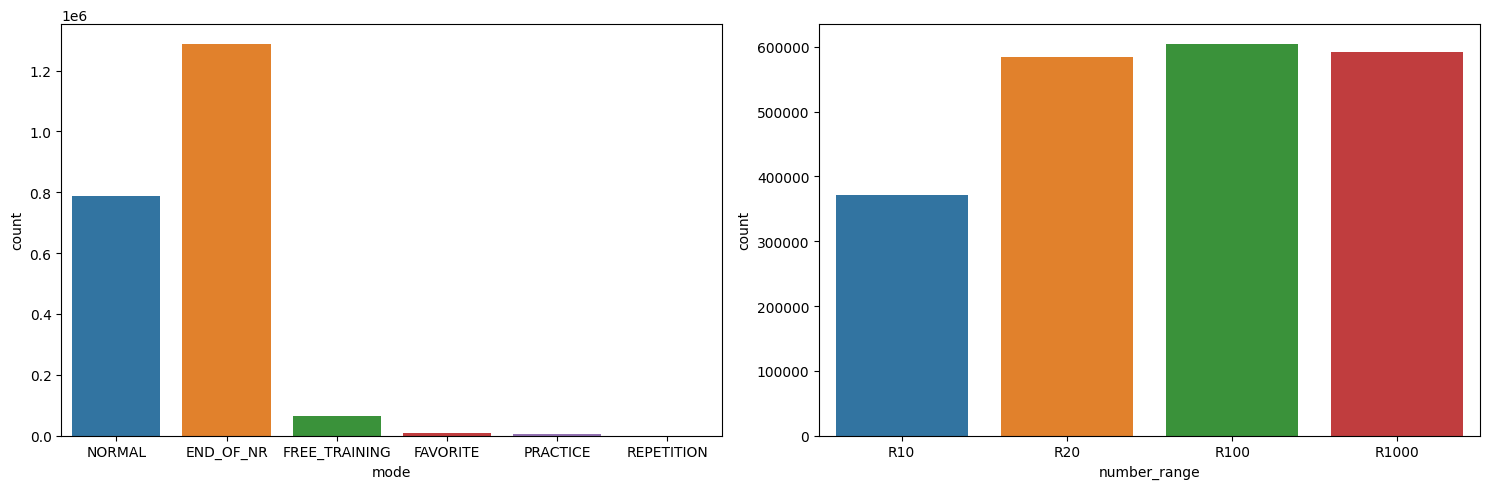

In [9]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
sns.countplot(data = pd.DataFrame(events['mode']), x = 'mode', ax = axs[0])
sns.countplot(data = pd.DataFrame(events['number_range']), x = 'number_range', ax = axs[1])
plt.tight_layout()

In [10]:
#guided = all except free and practice
# sort the events and subtasks dataframe to only keep NORMAL and FREE_TRAINING data
interested_mode = ['NORMAL', 'FREE_TRAINING']
events_sorted = events[events['mode'].isin(interested_mode)]
subtasks_sorted = subtasks[subtasks['event_id'].isin(events_sorted.index)]
print(f'Length of the sorted events dataframe with only NORMAL and FREE_TRAINING data: {len(events_sorted)}\n % kept from original dataset : {round(len(events_sorted)/len(events), 4)}')
print(f'Length of the sorted subtasks dataframe with only NORMAL and FREE_TRAINING data: {len(subtasks_sorted)} \n % kept from original dataset : {round(len(subtasks_sorted)/len(subtasks), 4)}')

Length of the sorted events dataframe with only NORMAL and FREE_TRAINING data: 852371
 % kept from original dataset : 0.3901
Length of the sorted subtasks dataframe with only NORMAL and FREE_TRAINING data: 1169550 
 % kept from original dataset : 0.3339


## Features extraction

In [11]:
events_per_week = events_sorted[['user_id', 'game_name', 'learning_time_ms', 'number_range', 'start', 'end']]

events_per_week['week'] = pd.to_datetime(events_sorted['start']).dt.isocalendar().week
week_start_array = events_per_week.groupby(by = 'user_id')['week'].first()
user_rep = events_per_week.groupby(['user_id'])['week'].count()
print(week_start_array)
print(user_rep)

C:\Users\Maxime\AppData\Local\Temp\ipykernel_22388\3285131873.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_per_week['week'] = pd.to_datetime(events_sorted['start']).dt.isocalendar().week


user_id
2        34
3         8
4        36
5         8
6        40
         ..
64993    35
64994    20
64995     8
64996     6
64997     8
Name: week, Length: 60170, dtype: UInt32
user_id
2        41
3        18
4        19
5        19
6        29
         ..
64993    11
64994     9
64995     2
64996     5
64997    24
Name: week, Length: 60170, dtype: int64


In [12]:
# Create the per week dataframes
events_per_week = events_sorted[['user_id', 'game_name', 'learning_time_ms', 'number_range', 'start', 'end']]

#events df
events_per_week['week'] = pd.to_datetime(events_sorted['start']).dt.isocalendar().week
week_start_array = events_per_week.groupby(by = 'user_id')['week'].first()
user_rep = events_per_week['user_id'].apply(lambda x: len(x))
#print(week_start)2
#print(user_rep)
week_start_events= np.array([])
for idx, i in enumerate(np.array(user_rep)):
    week_start_events = np.concatenate((week_start_events, np.full(i, np.array(week_start_array)[idx])))


events_per_week['week_start'] = week_start_events
events_per_week['week_upd'] = events_per_week['week'] - events_per_week['week_start']

events_per_week.head()

C:\Users\Maxime\AppData\Local\Temp\ipykernel_22388\74677296.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_per_week['week'] = pd.to_datetime(events_sorted['start']).dt.isocalendar().week


TypeError: object of type 'int' has no len()

In [47]:
#subtasks df
subtasks_per_week = subtasks_sorted[['event_id', 'user_id','correct', 'subtask_finished_timestamp']]
subtasks_per_week['week'] = pd.to_datetime(subtasks_sorted['subtask_finished_timestamp']).dt.isocalendar().week
week_start_array = subtasks_per_week.groupby(by = 'user_id')['week'].first()
user_rep = subtasks_per_week.groupby(['user_id'])['event_id'].count()
#print(week_start)
#print(user_rep)
week_start_subtasks= np.array([])
for idx, i in enumerate(np.array(user_rep)):
    week_start_subtasks = np.concatenate((week_start_subtasks, np.full(i, np.array(week_start_array)[idx])))


subtasks_per_week['week_start'] = week_start_subtasks
subtasks_per_week['week_upd'] = subtasks_per_week['week'] - subtasks_per_week['week_start']

subtasks_per_week.head()

C:\Users\Maxime\AppData\Local\Temp\ipykernel_14124\1358145601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subtasks_per_week['week'] = pd.to_datetime(subtasks_sorted['subtask_finished_timestamp']).dt.isocalendar().week
C:\Users\Maxime\AppData\Local\Temp\ipykernel_14124\1358145601.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subtasks_per_week['week_start'] = week_start_subtasks
C:\Users\Maxime\AppData\Local\Temp\ipykernel_14124\1358145601.py:14: SettingWithCopyWarning: 
A value is trying to be

,event_id,user_id,correct,subtask_finished_timestamp,week,week_start,week_upd
subtask_id,,,,,,,
1,1,2,False,2020-08-20T07:14:29.954Z,34,34.0,0.0
2,1,2,True,2020-08-20T07:14:29.954Z,34,34.0,0.0
3,3,2,True,2020-08-21T07:02:35.954Z,34,34.0,0.0
4,4,2,True,2020-08-24T07:03:07.167Z,35,34.0,1.0
5,5,2,True,2020-08-26T06:47:29.872Z,35,34.0,1.0


In [13]:
WEEKS_A_YEAR = 52 
df_events = events_sorted[['user_id', 'game_name', 'learning_time_ms', 'number_range', 'start', 'end']]
df_subtasks = subtasks_sorted[['event_id', 'user_id','correct', 'subtask_finished_timestamp']]

years = pd.to_datetime(df_events['start'], infer_datetime_format=True).dt.isocalendar().year
first_year = years.min()
df_events["week"] = pd.to_datetime(df_events['start'], infer_datetime_format=True).dt.isocalendar().year-first_year
df_events["week"] = df_events["week"]*WEEKS_A_YEAR +pd.to_datetime(events['start'], infer_datetime_format=True).dt.isocalendar().week
start_weeks = pd.Series(df_events.groupby(by="user_id").min()["week"], name="start_weeks")
df_subtasks["week"] = pd.to_datetime(df_subtasks['subtask_finished_timestamp'], infer_datetime_format=True).dt.isocalendar().year-first_year
df_subtasks["week"] = df_subtasks["week"]*WEEKS_A_YEAR+pd.to_datetime(df_subtasks['subtask_finished_timestamp'], infer_datetime_format=True).dt.isocalendar().week
# Now actually change it to each user starting with week 0
for user, start in start_weeks.items():
    df_events.loc[df_events["user_id"] == user, "week"] = df_events[df_events["user_id"] == user]["week"]-start
    df_subtasks.loc[df_subtasks["user_id"] == user, "week"] = df_subtasks[df_subtasks["user_id"] == user]["week"]-start

C:\Users\Maxime\AppData\Local\Temp\ipykernel_22388\373877476.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events["week"] = pd.to_datetime(df_events['start'], infer_datetime_format=True).dt.isocalendar().year-first_year
C:\Users\Maxime\AppData\Local\Temp\ipykernel_22388\373877476.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events["week"] = df_events["week"]*WEEKS_A_YEAR +pd.to_datetime(events['start'], infer_datetime_format=True).dt.isocalendar().week
C:\Users\Maxime\AppData\Local\Temp\i

In [14]:
df_events['difficulty'] = df_events['number_range'].replace({'R10': 1, 'R20': 2, 'R100': 3, 'R1000': 4})
#df_events.loc[df_events2['number_range'] == 'R10', 'number_range'] = 1
df_events.head()

C:\Users\Maxime\AppData\Local\Temp\ipykernel_22388\1886640849.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_events['difficulty'] = df_events['number_range'].replace({'R10': 1, 'R20': 2, 'R100': 3, 'R1000': 4})


,user_id,game_name,learning_time_ms,number_range,start,end,week,difficulty
event_id,,,,,,,,
1,2,Subitizing,13094.0,R10,2020-08-20T07:13:50.876Z,2020-08-20T07:14:30.108Z,0,1
3,2,Conversion,15879.0,R10,2020-08-21T07:02:20.112Z,2020-08-21T07:02:36.221Z,0,1
4,2,Landing,6075.0,R10,2020-08-24T07:02:59.855Z,2020-08-24T07:03:07.382Z,1,1
5,2,Landing,6910.0,R10,2020-08-26T06:47:21.504Z,2020-08-26T06:47:30.050Z,1,1
6,2,Calculator,7507.0,R20,2020-08-26T07:20:58.766Z,2020-08-26T07:21:06.439Z,1,2


In [15]:
df_subtasks.head()

,event_id,user_id,correct,subtask_finished_timestamp,week
subtask_id,,,,,
1,1,2,False,2020-08-20T07:14:29.954Z,0
2,1,2,True,2020-08-20T07:14:29.954Z,0
3,3,2,True,2020-08-21T07:02:35.954Z,0
4,4,2,True,2020-08-24T07:03:07.167Z,1
5,5,2,True,2020-08-26T06:47:29.872Z,1


In [16]:
#Extracting the features
features = pd.DataFrame()
features['# games'] = df_events.groupby(['user_id', 'week'])['game_name'].count()
features['# different games'] = df_events.groupby(['user_id', 'week'])['game_name'].unique().apply(lambda example : len(example))
features['learning_time'] = df_events.groupby(['user_id', 'week'])['learning_time_ms'].sum()
features['% correct'] = df_subtasks.groupby(['user_id','week'])['correct'].apply(lambda example: sum(example)/len(example))
features['avg difficulty'] = df_events.groupby(['user_id','week'])['difficulty'].mean()
print(f'Length of features dataframe : {len(features)}')
features.head()

Length of features dataframe : 425783


# games  # different games  learning_time  % correct  \
user_id week                                                         
2       0           2                  2        28973.0   0.666667   
        1           4                  3        22240.0   1.000000   
        3           3                  1        19819.0   0.666667   
        4           1                  1         7239.0   1.000000   
        5           2                  1        68088.0   0.500000   

              avg difficulty  
user_id week                  
2       0                1.0  
        1                1.5  
        3                3.0  
        4                3.0  
        5                3.0

In [30]:
def create_smaller_dataset(events, subtasks, nb_of_considered_users):
    #random sample on users
    different_users = np.array(events['user_id'].unique())
    events_small = events.loc[events['user_id'].isin(np.random.choice(different_users, nb_of_considered_users))]
    subtasks_small = subtasks.loc[subtasks['user_id'].isin(np.random.choice(different_users, nb_of_considered_users))]
    return events_small, subtasks_small

test_events, test_subtasks = create_smaller_dataset(df_events, df_subtasks, 500)
print(len(test_events['user_id'].unique()))
print(len(test_events))
print(len(test_subtasks['user_id'].unique()))
print(len(test_subtasks))
test_events.head()

499
6396
499
8743


,user_id,game_name,learning_time_ms,number_range,start,end,week,difficulty
event_id,,,,,,,,
10872,327,Subitizing,19048.0,R10,2022-10-10T07:52:38.276Z,2022-10-10T07:54:08.117Z,0,1
10873,327,Subitizing,4212.0,R10,2022-10-11T06:53:29.054Z,2022-10-11T06:53:35.904Z,0,1
10874,327,Scale: Decomposition,17735.0,R10,2022-10-11T08:00:29.301Z,2022-10-11T08:00:47.175Z,0,1
10875,327,Sliderule,5678.0,R10,2022-10-11T08:55:59.767Z,2022-10-11T08:57:10.075Z,0,1
10876,327,Comparison,4095.0,R10,2022-10-17T06:47:15.211Z,2022-10-17T06:48:55.993Z,1,1


In [121]:
different_users = np.array(features.index.get_level_values('user_id').unique())
small_features = features.iloc[features.index.get_level_values('user_id').isin(np.random.choice(different_users, 100))]
print(f'Length of small features dataframe : {len(small_features)}')
small_features.head()

Length of small features dataframe : 644


# games  # different games  learning_time  % correct  \
user_id week                                                         
342     0           1                  1        11851.0   0.000000   
        1           5                  5        86831.0   0.777778   
529     0           2                  1       149057.0        NaN   
        1           1                  1        13396.0        NaN   
        3           7                  4       200699.0        NaN   

              avg difficulty  
user_id week                  
342     0                1.0  
        1                2.2  
529     0                1.0  
        1                1.0  
        3                1.0

In [140]:
effort = pd.DataFrame({
  "# games": small_features['# games'],  
  "# different games": small_features['# different games'],  
  "learning_time": small_features['learning_time'],
  "% correct": small_features['% correct'],
  "avg difficulty": small_features['avg difficulty']  
})
#print(f"Count of users in effort: {len(events.groupby(by=['user_id']).sum().index)}")
effort.describe()

,# games,# different games,learning_time,% correct,avg difficulty
count,644.000000,644.000000,644.000000,557.000000,644.000000
mean,1.880435,1.442547,27028.850932,0.655649,2.138751
std,1.510870,0.783653,39360.026965,0.391346,1.101912
min,1.000000,1.000000,950.000000,0.000000,1.000000
25%,1.000000,1.000000,7357.000000,0.500000,1.000000
50%,1.000000,1.000000,14757.000000,0.750000,2.000000
75%,2.000000,2.000000,28483.750000,1.000000,3.000000
max,12.000000,5.000000,513278.000000,1.000000,4.000000


## Regularity features

In [132]:
# create smaller datasets --> dataset.model
different_events = np.array(events_sorted.index.unique())
different_subtasks = np.array(subtasks_sorted.index.unique())

events_model = events_sorted.iloc[events_sorted.index.isin(np.random.choice(different_events, 1000))]
subtasks_model = subtasks_sorted.iloc[subtasks_sorted.index.isin(np.random.choice(different_subtasks, 1000))]
print(f'Length of small events dataframe : {len(events_model)}')
print(f'Length of small subtasks dataframe : {len(subtasks_model)}')
events_model.head()

Length of small events dataframe : 999
Length of small subtasks dataframe : 1000


,user_id,mode,game_name,learning_time_ms,subtasks,number_range,start,end,skill_id,type
event_id,,,,,,,,,,
1071,30,NORMAL,Calculator,19810.0,"[{'range': 'R20', 'answerMode': 'RESULT', 'cor...",R20,2021-11-15T17:22:02.981Z,2021-11-15T17:22:22.916Z,56.0,task
6758,204,NORMAL,Landing,7512.0,"[{'range': 'R100', 'correct': False, 'lowerBou...",R100,2021-11-22T10:46:29.835Z,2021-11-22T10:46:39.290Z,110.0,task
12341,369,NORMAL,Estimation on Number Line,7894.0,"[{'answer': 98, 'solutionRepresentation': 'NUM...",R100,2021-02-22T12:03:14.720Z,2021-02-22T12:03:22.813Z,100.0,task
17204,487,NORMAL,Landing,6986.0,"[{'range': 'R20', 'correct': True, 'lowerBound...",R20,2021-11-05T08:03:40.333Z,2021-11-05T08:03:49.413Z,51.0,task
17765,499,FREE_TRAINING,Scale: Subtraction,8402.0,"[{'range': 'R10', 'answerMode': 'OPERAND_B', '...",R10,2022-12-14T16:00:37.611Z,2022-12-14T16:00:45.981Z,0.0,task


In [133]:
# Helper functions
# FT as defined in 4.4 Frequency Based Measures of "How to quantify Student's regularity"
def fourier_transform(Xi, f, n):
    return np.dot(np.exp(-2j * np.pi * f * n), Xi)

In [134]:
WEEKS = 15
## Regularity feature for both events and subtasks
# Heavy influence of code from https://github.com/epfl-ml4ed/flipped-classroom/blob/master/extractor/feature/reg_periodicity.py
subtasks_model["date"] = pd.to_datetime(subtasks_sorted['subtask_finished_timestamp'], infer_datetime_format=True)
events_model["date"] = pd.to_datetime(events_model['start'], infer_datetime_format=True)

# We have periodicity of week day
def period_of_week_day(users_events):
    # Convert date to days starting from 0
    days = users_events["date"].values.astype(np.int64) // 10 ** 9 // (24 * 3600)
    days -= min(days)
    period_length = WEEKS * 7
    activity = np.array([int(d in days) for d in range(period_length)])  # 1 if active at day d, 0 o.w.
    n = np.arange(period_length)
    return abs(fourier_transform(activity, 1 / 7, n))
event_week_day_periodicity = events_model.groupby(by=["user_id"]).apply(lambda users_events: period_of_week_day(users_events))
subtask_week_day_periodicity = subtasks_model.groupby(by=["user_id"]).apply(lambda users_tasks: period_of_week_day(users_tasks))

# We have periodicity of week hour
def period_of_week_hour(users_events):
    period_length = WEEKS * 7 * 24
    hours = users_events['date'].values.astype(np.int64) // 10 ** 9 // 3600
    hours -= min(hours)
    activity = np.array([int(t in hours) for t in range(period_length)])
    n = np.arange(period_length)
    return abs(fourier_transform(activity.flatten(), 1 / (7 * 24), n))
event_week_hour_periodicity = events_model.groupby(by=["user_id"]).apply(lambda users_events: period_of_week_hour(users_events))
subtask_week_hour_periodicity = subtasks_model.groupby(by=["user_id"]).apply(lambda users_tasks: period_of_week_hour(users_tasks))

# We have periodicity of day hour
def period_of_day_hour(users_events):
    # Convert date to hours starting from 0
    hours = users_events['date'].values.astype(np.int64) // 10 ** 9 // 3600
    hours -= min(hours)
    period_length = WEEKS * 7 * 24
    activity = np.array([int(t in hours) for t in range(period_length)])  # 1 if active at hour t 0 o.w.
    if np.sum(activity) == 0:
        print(f'Feature period_of_day_hour is invalid: the m1 mode is invalid')
        raise ValueError
    n = np.arange(period_length)
    return abs(fourier_transform(activity, 1 / 24, n))
event_day_hour_periodicity = events_model.groupby(by=["user_id"]).apply(lambda users_events: period_of_day_hour(users_events))
subtask_day_hour_periodicity = subtasks_model.groupby(by=["user_id"]).apply(lambda users_tasks: period_of_day_hour(users_tasks))

C:\Users\Maxime\AppData\Local\Temp\ipykernel_14124\2325121236.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subtasks_model["date"] = pd.to_datetime(subtasks_sorted['subtask_finished_timestamp'], infer_datetime_format=True)
C:\Users\Maxime\AppData\Local\Temp\ipykernel_14124\2325121236.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_model["date"] = pd.to_datetime(events_model['start'], infer_datetime_format=True)


In [135]:
regularity = pd.DataFrame({
  "event_week_day_periodicity": event_week_day_periodicity,  
  "subtask_week_day_periodicity": subtask_week_day_periodicity,  
  "event_week_hour_periodicity": event_week_hour_periodicity,  
  "subtask_week_hour_periodicity": subtask_week_hour_periodicity,  
  "event_day_hour_periodicity": event_day_hour_periodicity,  
  "subtask_day_hour_periodicity": subtask_day_hour_periodicity,  
})
print(f"Count of users in regularity: {len(regularity.index)}")
regularity.describe()

Count of users in regularity: 1934


,event_week_day_periodicity,subtask_week_day_periodicity,event_week_hour_periodicity,subtask_week_hour_periodicity,event_day_hour_periodicity,subtask_day_hour_periodicity
count,984.000000,978.000000,984.000000,978.000000,984.000000,978.000000
mean,1.002020,1.005818,1.002003,1.006731,1.006280,1.013362
std,0.055429,0.082039,0.057678,0.087015,0.075094,0.108905
min,0.445042,0.445042,0.408504,0.408504,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2.000000,2.000000,1.996854,1.996854,2.000000,2.000000


*Your discussion about your processing decisions goes here*

## Task 2: Model Building

Train a model for your research question. 

In [136]:
# Your code for training a model goes here

## Make similarity matrices for each feature at first (later try multivariate)

# For the regularity features we need to make a similarity matrix with euclidian distance
def eucl_similarity_func(u, v):
    # Would directly give the similarity using euclidian distance
    return 1/(1+euclidean(u,v))

def gaussian_kernel(distance_mat, sigma):
    return np.exp(-distance_mat ** 2 / 2.*sigma ** 2)

# Gives the distance matrix in vector form, i.e. upper triangular part of the distance matrix
reg_dists = pdist(regularity, metric='euclidean')
# Reshape and put into pd
reg_dists = pd.DataFrame(squareform(reg_dists), columns=regularity.index, index=regularity.index)
# Now apply the gaussian kernel to make a similarity matrix
sigma = 1 # TODO is a hyper parameter tuning needed
reg_dists = gaussian_kernel(reg_dists, sigma)
print(f"Shape of regularity distance matrix: {reg_dists.shape}")

# For the time series features we use DTW

Shape of regularity distance matrix: (1934, 1934)


In [142]:
def dtw_distance_func(u, v):
    #dtw(u, v, dist="square", method="sakoechiba", window=10)
    resolution, radius = 5, 2
    dtw_multiscale = dtw(
        u, v, dist='square', method='multiscale',
        options={'resolution': resolution, 'radius': radius}, return_path=False
    )
    return dtw_multiscale


In [137]:
# https://github.com/epfl-ml4ed/fc-clustering/blob/234f6c65dbc88869d2f9ffcf937df63381546f9a/src/features/preprocess.py#L5
def normalize(distance_matrix):
    # fix infinity
    distance_matrix[np.isinf(distance_matrix)] = 0

    # robust standarizatoin
    flat_nan = distance_matrix[~np.isnan(distance_matrix)]
    median = np.median(flat_nan)
    q1 = np.percentile(flat_nan, 10)
    q3 = np.percentile(flat_nan, 90)
    IQR = q3 - q1
    if IQR==0:
        IQR = 1
    S =  (distance_matrix - median) / IQR

    # then normalization
    range_matrix = np.max(S) - np.min(S)
    normalized = (S - np.min(S)) / range_matrix
    return normalized

In [143]:
dimension_sim_matrx = {
    "regularity": reg_dists,
    "effort_time_online": None,
    "effort_events_done": None,
    "effort_subtasks_done": None,
}
for feature in effort.columns:
    # First get the relevant feature
    reshaped_feature = effort[effort.index.get_level_values(1) <= WEEKS][feature][:6000]
    # Now unstack the user_id and fill with 0 all nan
    # TODO the fillna does not make sense, what to do??
    # Probably we want to not use first x weeks, but rather x weeks of data points
    reshaped_feature = reshaped_feature.unstack(level=1).fillna(0)
    #print(reshaped_feature.head(3))
    # Now given this matrix, we can calculate the distance matrix
    dist_mat_feature = pdist(reshaped_feature, metric=dtw_distance_func)
    # Reshape and put into pd
    dist_mat_feature = pd.DataFrame(squareform(dist_mat_feature), columns=reshaped_feature.index, index=reshaped_feature.index)
    sigma = 1 # TODO is a hyper parameter tuning needed per feature
    # Last step is converting this into a similarity matrix using the gaussian kernel using silhoutte score
    dimension_sim_matrx[f"effort_{feature}"] = gaussian_kernel(dist_mat_feature, sigma)
    print(f"Done with {feature} distance matrix: {dimension_sim_matrx[f'effort_{feature}'].shape} shape")

NameError: name 'dtw' is not defined

In [ ]:
# Save the dimension similarity matrices to a pickle file
def save_sim_mat():
    with open('dimension_sim_matrx.pickle', 'wb') as handle:
        pickle.dump(dimension_sim_matrx, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_sim_mat():
    global dimension_sim_matrx
    with open('dimension_sim_matrx.pickle', 'rb') as handle:
        dimension_sim_matrx = pickle.load(handle)
load_sim_mat()

In [ ]:
# Feasability check of growing curve for time used
import scipy
xdata = np.array([16, 142, 344, 851])
ydata = np.array([0.01, 0.5, 1.15, 13.1]) # minutes
# Plot the actual data
plt.plot(xdata, ydata, ".", label="Data")

# The actual curve fitting happens here
# Number of comparisions has computational order of O(n**2)
ex = lambda t,a,b: a+b*t**2
optimizedParameters, pcov = scipy.optimize.curve_fit(ex, xdata, ydata) 

# Use the optimized parameters to plot the best fit
plot_x = np.linspace(0, 7000)
plt.plot(plot_x, ex(plot_x, *optimizedParameters), label="fit")

print(f"According to fitted curve, doing 70k students takes {ex(70000, *optimizedParameters):.2f} minutes")

# Show the graph
plt.legend()
plt.show()

In [ ]:
# Spectral clustering

SEED = 111
affinity = np.sum([
    dimension_sim_matrx["effort_subtasks_done"],
    dimension_sim_matrx["effort_events_done"],
    #dimension_sim_matrx["effort_time_online"], # For now time_online is probably wrong bc of the fillna
    dimension_sim_matrx["regularity"]], axis=0)
print(f"Shape of affinity matrix: {affinity.shape}")

# Code from https://github.com/epfl-ml4ed/fc-clustering/blob/234f6c65dbc88869d2f9ffcf937df63381546f9a/src/models/clustering.py
def spectral_clustering(affinity,  n_clusters=3, random_state=SEED):
    """
    Spectral clustering
    :param affinity: np array of data points or affinity matrix
    :param n_clusters: number of clusters
    :return: tuple (kmeans, maps, eigenvals_sorted)
        WHERE
        kmeans scikit learn clustering object
        maps is np array of transformed data points
        eigenvals_sorted is np array with ordered eigenvalues
    """
    # Compute eigengap heuristic
    L = laplacian(affinity, normed=True)
    eigenvals, _ = linalg.eig(L)
    eigenvals = np.real(eigenvals)
    eigenvals_sorted = eigenvals[np.argsort(eigenvals)]

    # Create embedding
    random_state = np.random.RandomState(random_state)
    maps = spectral_embedding(affinity, n_components=n_clusters,
                              random_state=random_state,
                              drop_first=False)

    # Cluster the points using k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state = random_state)
    kmeans.fit(maps)

    return kmeans, maps, eigenvals_sorted

*Your discussion about your model training goes here*

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [ ]:
# Your code for model evaluation goes here

# Again code from FC clustering
def compute_bic(kmeans, X):
    """
    Computes the BIC metric
    :param kmeans: clustering object from scikit learn
    :param X: np array of data points
    :return: BIC
    """
    # Adapted from: https://stats.stackexchange.com/questions/90769/using-bic-to-estimate-the-number-of-k-in-kmeans
    # assign centers and labels
    BIC = -1
    try:
        centers = [kmeans.cluster_centers_]
        labels  = kmeans.labels_
        #number of clusters
        m = kmeans.n_clusters
        # size of the clusters
        n = np.bincount(labels)
        #size of data set
        N, d = X.shape

        #compute variance for all clusters beforehand
        cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]],
                 'euclidean')**2) for i in range(m)])

        const_term = 0.5 * m * np.log(N) * (d+1)

        LL = np.sum([n[i] * np.log(n[i]) -
                   n[i] * np.log(N) -
                 ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
                 ((n[i] - 1) * d/ 2) for i in range(m)])

        BIC = LL - const_term
    except  Exception as e:
        print(e)
        print("error")
        pass

    return 

def plot_metrics(n_clusters_list, metric_dictionary):
    """
    Plots metric dictionary (auxilary function)
    [Optional]
    :param n_clusters_list: List of number of clusters to explore
    :param metric_dictionary:
    """
    fig = plt.figure(figsize=(12, 10), dpi=80)
    i = 1

    for metric in metric_dictionary.keys():
        plt.subplot(2, 2, i)

        if metric == 'Eigengap':
            clusters = len(n_clusters_list)
            eigenvals_sorted = metric_dictionary[metric]
            plt.scatter(range(1, len(eigenvals_sorted[:clusters * 2]) + 1), eigenvals_sorted[:clusters * 2])
            plt.xlabel('Eigenvalues')
            plt.xticks(range(1, len(eigenvals_sorted[:clusters * 2]) + 1))
        else:
            plt.plot(n_clusters_list, metric_dictionary[metric], '-o')
            plt.xlabel('Number of clusters')
            plt.xticks(n_clusters_list)
        plt.ylabel(metric)
        i += 1
    return fig

def get_heuristics_spectral(X, n_clusters_list=range(2, 10)):
    """
    Calculates heuristics for optimal number of clusters with Spectral Clustering
    :param X: np array of data points
    :param n_clusters_list: List of number of clusters to explore
    """
    silhouette_list = []
    distortion_list = []
    bic_list = []
    eigengap_list = []

    for n in n_clusters_list:
        kmeans, proj_X, eigenvals_sorted = spectral_clustering(X, n)
        y_pred = kmeans.labels_

        if n == 1:
            silhouette = np.nan
        else:
            silhouette = silhouette_score(proj_X, y_pred)
        silhouette_list.append(silhouette)

        distortion = kmeans.inertia_
        distortion_list.append(distortion)

        bic = compute_bic(kmeans, proj_X)
        bic_list.append(bic)

    metric_dictionary = {'BIC': bic_list,
                         'Distortion': distortion_list,
                         'Silhouette': silhouette_list,
                         #https://ai.stackexchange.com/questions/35262/how-can-i-select-k-value-of-k-means-from-eigengap
                         'Eigengap': eigenvals_sorted}

    plot_metrics(n_clusters_list, metric_dictionary)

get_heuristics_spectral(affinity)

*Your discussion/interpretation about your model's behavior goes here*

## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*